In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import regex
import re
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.metrics import classification_report
import fastText
plt.style.use('ggplot')
%matplotlib notebook

In [2]:
def fonction_nettoyage_text(df):
    # supprission des ponctuations
    rm_ponct = str.maketrans('','',string.punctuation)
    df = df.apply(lambda x:x.translate(rm_ponct))
    # suppression les unicodes
    df = df.apply(lambda x:x.encode("ascii","ignore").decode("utf-8"))
                                                
    # suppression des URLs
    df = df.apply(lambda x:re.sub(r'http\S+',"",x))
    
    # suppression des stopwords
    stop_en = stopwords.words("english")
    df = df.apply(lambda x:" ".join(x.lower() for x in np.str(x).split() if x.lower() not in stop_en))
                                                  # Lemmatisation
    df = df.apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
                  
    return(df)

In [3]:
# import des données
dataset = pd.read_csv("data_set_version_final.csv")
dataset.resume=fonction_nettoyage_text(dataset.resume)

## Split Train Test:

In [4]:
X_train,X_test,Y_train,y_test = train_test_split(dataset.resume,dataset.Labels,test_size=0.3,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.3,shuffle=True)

###  Exporter les données train /test/val:

In [5]:
x_train.to_csv("FastTestFolder/xtrain.txt",index=False)
x_val.to_csv("FastTestFolder/xval.txt",index=False)
X_test.to_csv("FastTestFolder/Xtest.txt",index=False)

/home/tantely/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/home/tantely/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/home/tantely/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avo

In [91]:
from gensim.models.wrappers.fasttext import FastText as FT_wrapper
from gensim.test.utils import datapath
ft_home = '/home/tantely/fastText-0.2.0/fasttext'
corpus_file=datapath("/home/tantely/Documents/INSA_Rouen/Projet_fil_rouge/text_mining_fil_rouge/FastTestFolder/xtrain.txt")
model_wrapper = FT_wrapper.train(ft_home, corpus_file,model="cbow",size=100, word_ngrams=3)

In [92]:
print(model_wrapper)

FastText(vocab=9307, size=100, alpha=0.025)


## Avantage de fast text:
Peut supporter des mots qui ne se trouvent pas dans notre liste de mots

In [93]:
print("date" in model_wrapper.wv.vocab)
print(model_wrapper['data'])
print("detla" in model_wrapper.wv.vocab)
print(model_wrapper['detla'])

True
[-1.9779162  -0.6183992   0.5519615  -1.6733139   3.230172   -2.6278021
  0.31483445  3.5062203  -2.038922    1.4962673   0.74569154  4.566792
 -1.1736131   1.5683862   1.079804    0.08590926 -0.97349983  4.9090443
  0.9398931   2.2546976  -4.039697    1.352392   -1.6772919  -1.3568245
  1.2702034   0.45437762 -2.5144036   0.18867597  2.2707577  -3.4615958
 -1.0717793   1.6131573   2.8972316   4.1367774  -3.7431595   0.28831074
 -1.6446453  -0.9549903   5.31256     1.1414288  -0.22156781  0.9963823
  3.3572662  -0.55057204  4.9055715  -0.38408196 -0.8263342  -2.6389747
  3.7544897   5.42316     3.466717    1.7686934  -0.9030009  -3.2564623
  0.13441354  2.4824412   3.845665   -0.46850473 -0.9050389  -1.0315988
 -3.7294912   1.3466312   0.52212566 -4.020164    0.57544476  1.1061308
  1.2957108  -1.4687575  -4.2907834  -4.8955016   1.7747108   2.078431
 -3.0992472   2.6731412   1.0109537   0.14928277  2.9675093   3.9604902
 -3.0294034  -0.04015906  1.9334857   0.12172964 -2.2531621 

On peut alors calculer la similarité de deux mots sans même si l'un des deux mots ne se trouvent pas dans le corpus.

In [9]:
print("data" in model_wrapper.wv.vocab)
print("detla" in model_wrapper.wv.vocab)
model_wrapper.similarity("data", "detla")

True
False


/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.20074365

## Opération sur la similarité des mots:

In [76]:
model_wrapper.most_similar("data")

[('datasets', 0.9344339370727539),
 ('etldata', 0.9289052486419678),
 ('databricks', 0.9274758696556091),
 ('metadata', 0.9084570407867432),
 ('teradata', 0.8561747074127197),
 ('dat', 0.8412096500396729),
 ('datapower', 0.8365733623504639),
 ('datastage', 0.8362958431243896),
 ('database', 0.8343255519866943),
 ('datawarehouse', 0.8333402276039124)]

In [96]:
"e33" in model_wrapper

True

In [99]:
from gensim.models.wrappers.fasttext import FastText as FT_wrapper
from gensim.test.utils import datapath
import numpy as np
import os 
from sklearn.preprocessing import MinMaxScaler

ft_home ='/home/tantely/fastText-0.2.0/fasttext'

class FastTextTransformer:
    def __init__(self,inputFile,ft_home,path_to_data,model="cbow",size=100, word_ngrams=3):
        
        if not os.path.isfile(ft_home) :
            print("Path" ,ft_home,"does not exist")
            sys.exit(1)
        if not os.path.isfile(inputFile) :
            print("Path" ,ft_home,"does not exist")
            sys.exit(1)
        corpus_file=datapath(path_to_data)
        
        self.ft_home=ft_home
        self.corpus_file=corpus_file
        self.inputFile=inputFile
        self.model=model
        self.size=size
        self.word_ngrams=word_ngrams
        
        global model_wrapper
        
   
    def fit(self,X,y=None):
        X.to_csv(self.inputFile,index=False)
        corpus_file=datapath(self.inputFile)
        self.model_wrapper = FT_wrapper.train(self.ft_home, self.inputFile,model=self.model,size=self.size,word_ngrams=self.word_ngrams)
        return self
    
    def __average_word(self,X):
        return np.array([np.mean([self.model_wrapper[w] for w in words.split()if w in self.model_wrapper], axis=0) for words in X])

    def transform(self,X,y=None):
        Xres = self.__average_word(X)
        scaler = MinMaxScaler()
        scaler.fit(Xres)
        return scaler.transform(Xres)

In [100]:
ft_home ='/home/tantely/fastText-0.2.0/fasttext'
path_to_data="/home/tantely/Documents/INSA_Rouen/Projet_fil_rouge/text_mining_fil_rouge/FastTestFolder/xtrain.txt"
fasttextTransformer=FastTextTransformer(inputFile=path_to_data,ft_home=ft_home,path_to_data=path_to_data)
fasttextTransformer.fit(x_train)

/home/tantely/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [101]:
fastText_Xtrain=fasttextTransformer.transform(x_train)
fastText_Xval=fasttextTransformer.transform(x_val)
fastText_Xtest=fasttextTransformer.transform(X_test)

In [102]:
print(fastText_Xtest)

[[0.72156    0.4289699  0.70580566 ... 0.54075533 0.16326988 0.540159  ]
 [0.58053976 0.5274518  0.34363252 ... 0.429333   0.4579624  0.30335456]
 [0.62833226 0.53896874 0.34581628 ... 0.4746033  0.3172043  0.37369195]
 ...
 [0.5506351  0.4786835  0.5996773  ... 0.35937852 0.57142866 0.5539787 ]
 [0.8633179  0.12873453 0.7173184  ... 0.5391618  0.4352611  0.3862669 ]
 [0.49693567 0.26668185 0.70572495 ... 0.42394105 0.5345455  0.66468817]]


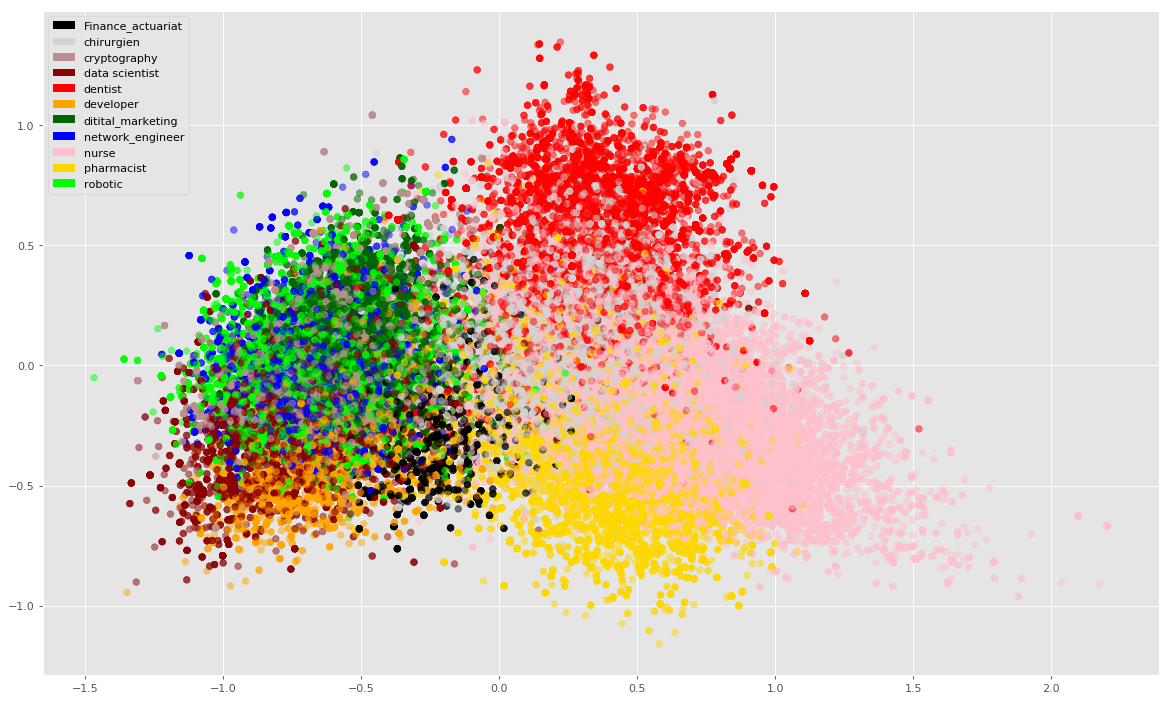

In [105]:
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches


color=["black","lightgray","rosybrown","darkred","red","orange","darkgreen","blue","pink","gold","lime"]
def affect_color(color_list,y):
    dict_col={name:color_list[k] for k,name in enumerate(np.unique(y)) }
    color_corr=[dict_col[k] for k in y]
    return color_corr , dict_col


X_pca = PCA().fit_transform(fastText_Xtrain)
coloration,color_dict=affect_color(color,y_train)

recs = [mpatches.Rectangle((0,0),1,1,fc=col) for col in color_dict.values()]

plt.figure(num=None, figsize=(18, 11), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=coloration,alpha=0.5)
plt.legend(recs,list(color_dict.keys()),loc='upper left');

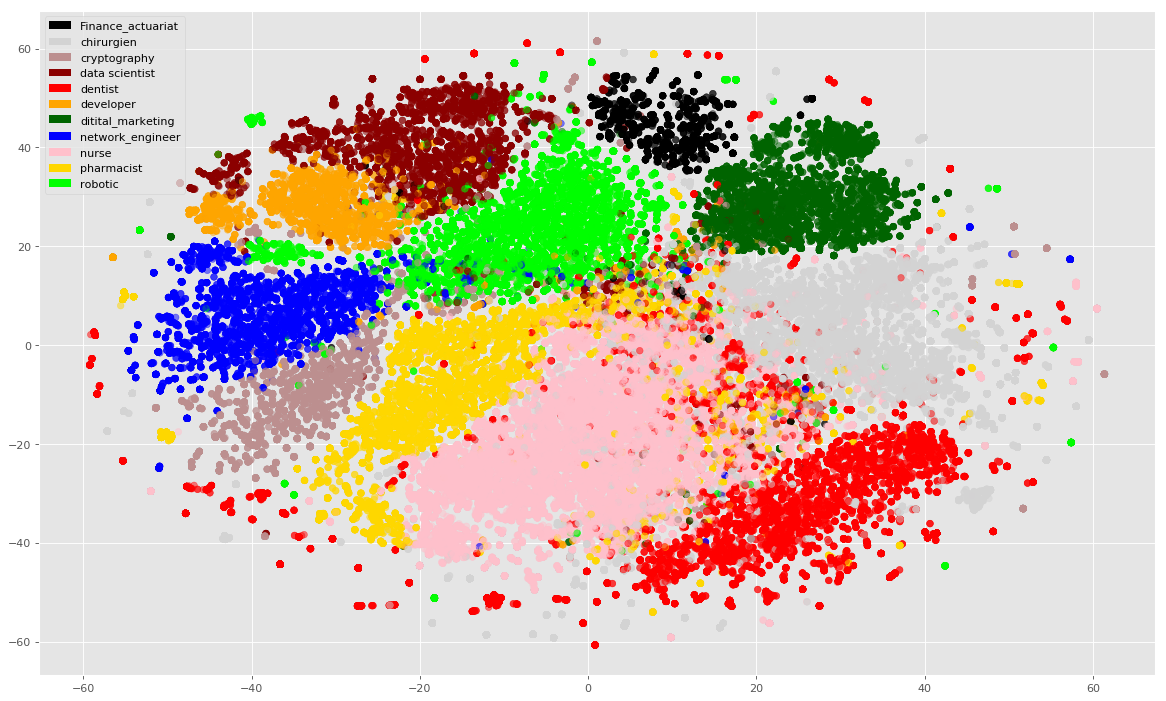

In [106]:
from sklearn.manifold import TSNE

color=["black","lightgray","rosybrown","darkred","red","orange","darkgreen","blue","pink","gold","lime"]
def affect_color(color_list,y):
    dict_col={name:color_list[k] for k,name in enumerate(np.unique(y)) }
    color_corr=[dict_col[k] for k in y]
    return color_corr , dict_col


X_tsne = TSNE().fit_transform(fastText_Xtrain)
coloration,color_dict=affect_color(color,y_train)

recs = [mpatches.Rectangle((0,0),1,1,fc=col) for col in color_dict.values()]

plt.figure(num=None, figsize=(18, 11), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=coloration,alpha=0.5)
plt.legend(recs,list(color_dict.keys()),loc='upper left');